Soft deadline: `27.03.2022`

# PART 1 - Attention (10 points)

Now we are familiar with the mechanism of attention and self-attention, let's try in practice to create such a mechanism with the numpy tool.

As we mentioned on the lecture, the attention mechanism is one of the strongest tools for solving practical problems today. On its variety - multi-headed attention, the most important architecture was built - Transformer, which is much easier to parallelize than recurrent networks, which significantly speeds up calculations.

## Attention mechanism

When using recurrent neural networks in a machine translation task, the decoder received the last hidden state of the encoder - containing information about the entire sentence.


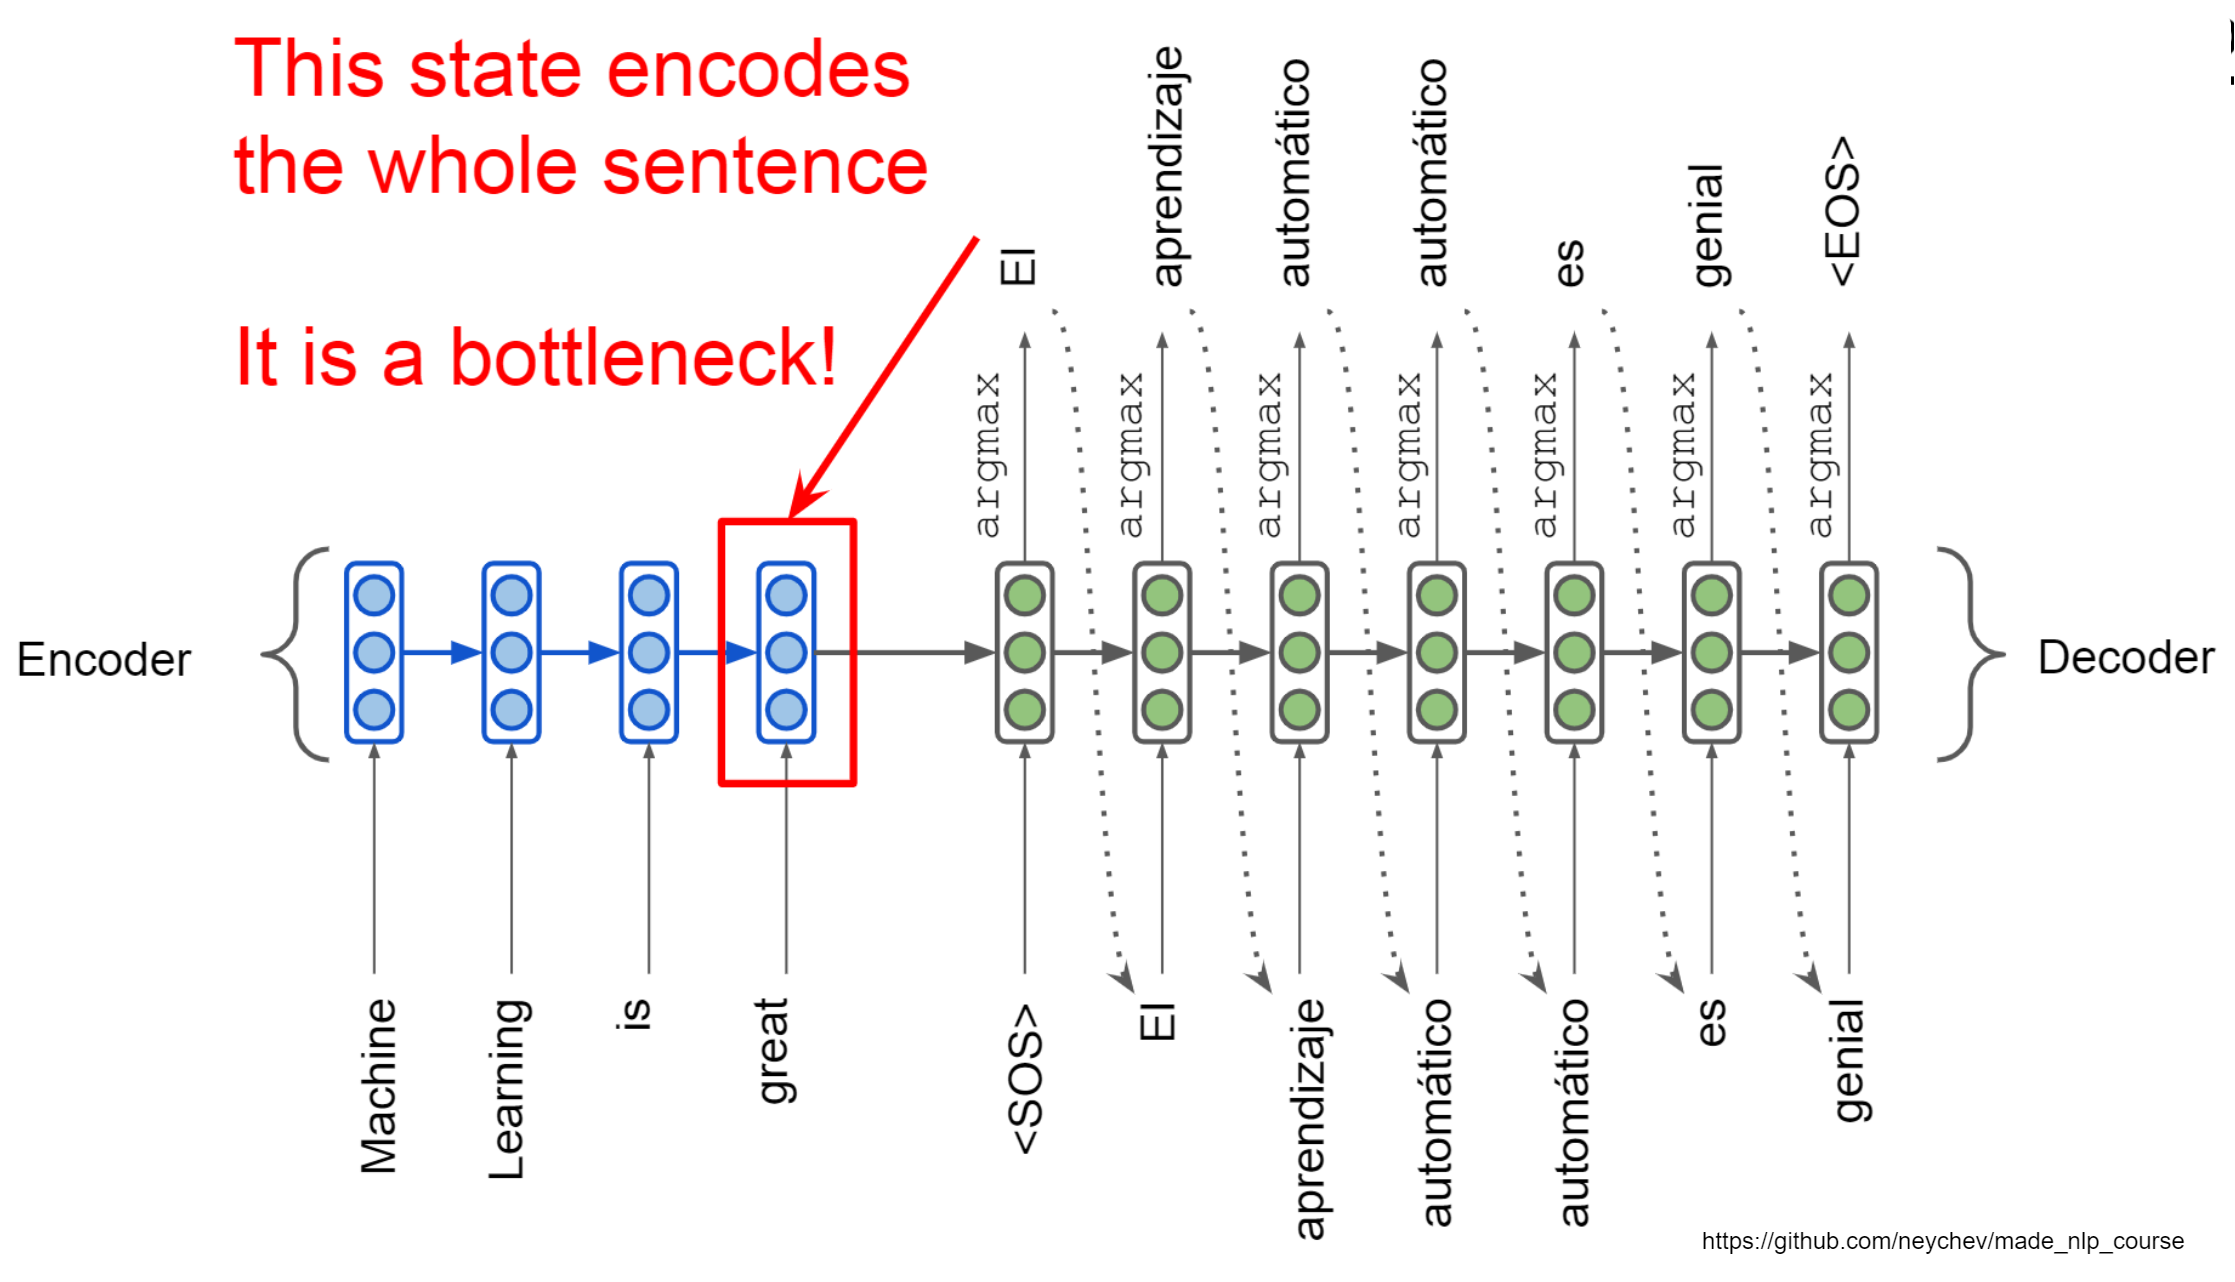

Hence, it is quite clear that such an input for the decoder may not be informative enough, because it is 1) limited to a small number of elements; 2) prone to give "more weight" to the last tokens encountered and tends to forget what was at the beginning of the text if it is long enough. Therefore, an attention mechanism has been proposed to overcome these problems by allowing each state of the decoder to look at all the states of the encoder. In other words, we let the model decide for itself which words to look at in order to generate the current translation word.



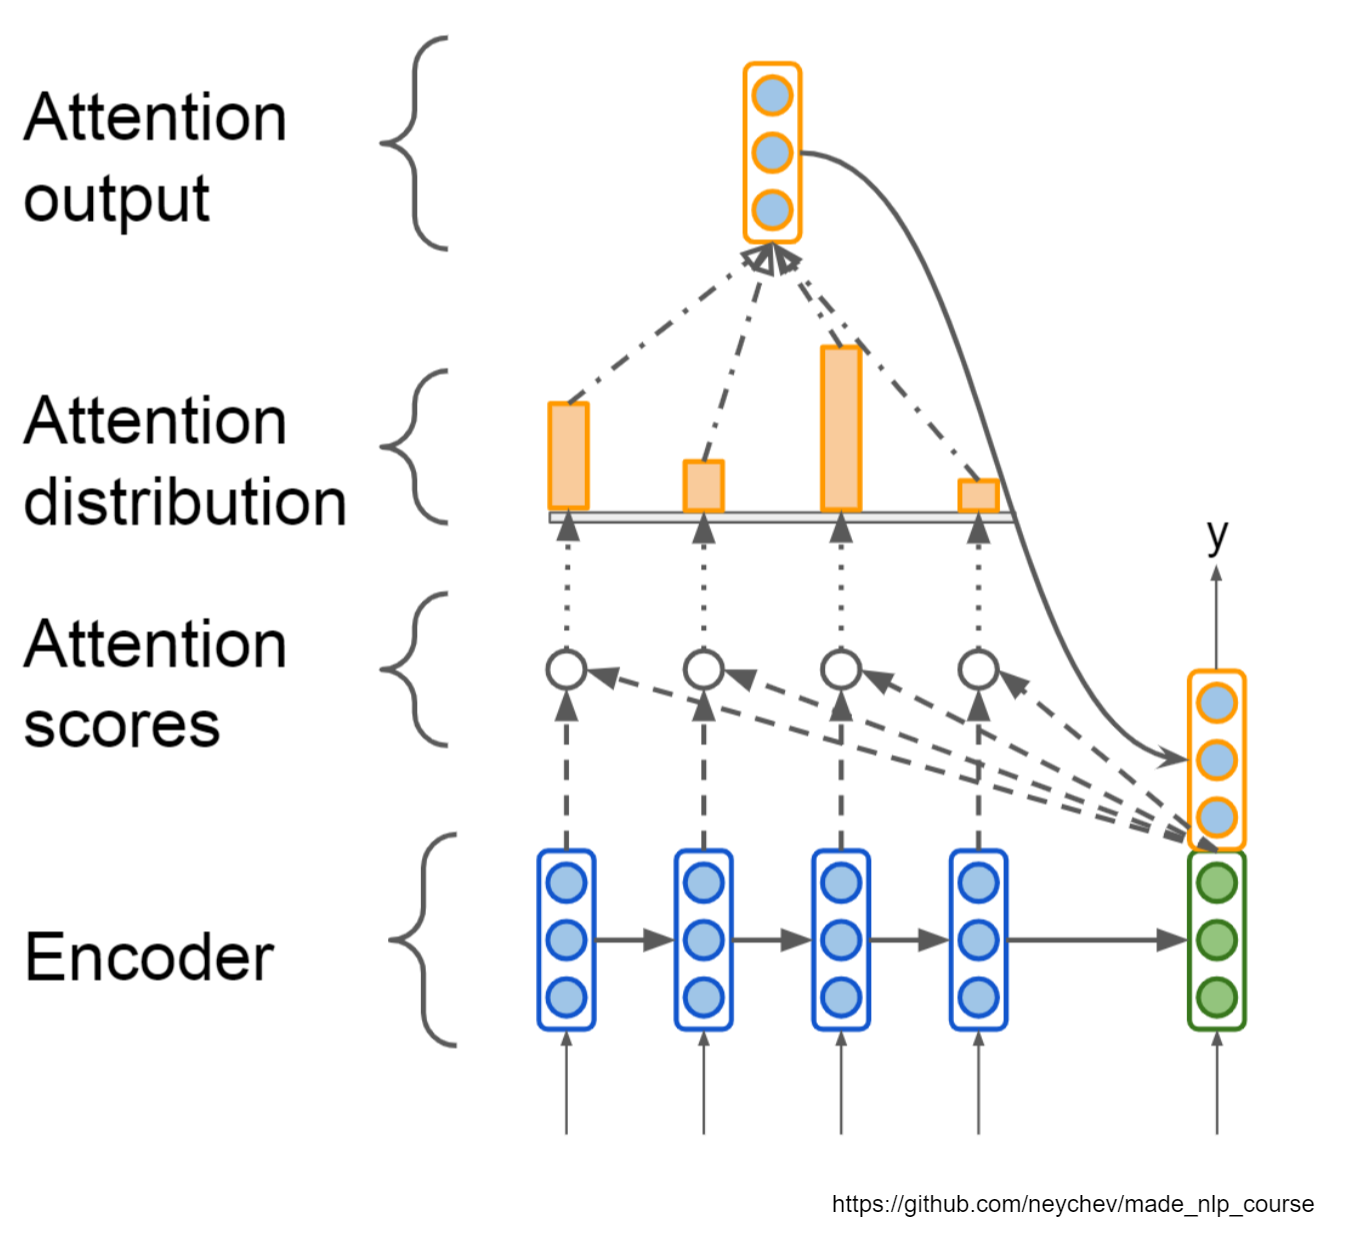

## Self-attention

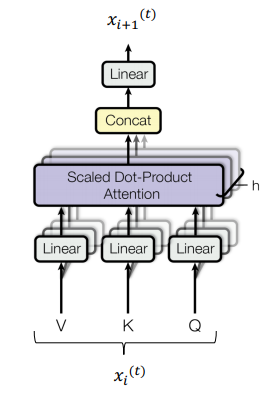

Technically, each word (token) in the text is translated into embedding (vector representation) and then multiplied by the matrices Q (query), K (key), V (value), which are learned in the learning process.

1. First you have the embedding of the word, which is multiplied with the matrices Q to get $q_1$, K for $k_1$ and V for $v_1$
1. Next, after each word is passed through the linear layer, it is necessary to calculate the score. It will help you understand how similar words are, for example, $q_1$ and $k_1$, by calculating a simple scalar product of $q_1k_1$. To obtain probabilities, it is necessary to take softmax from the estimates obtained (it should also be divided by $\sqrt{d}$). The probability multiplied by the value gives a new representation of the word.

In the basic version, a scalar product is used, which allows you to take into account the relationship between each embedding in the query with each word in the key. If the queries and keys belong to the same sequence, then we get **bidirectional self-attention (bidirectional self-attention)**. However, in many situations it is necessary to give access only to those words that were before the current one (**causal attention **). To do this, masks are used as an argument for the softmax function.

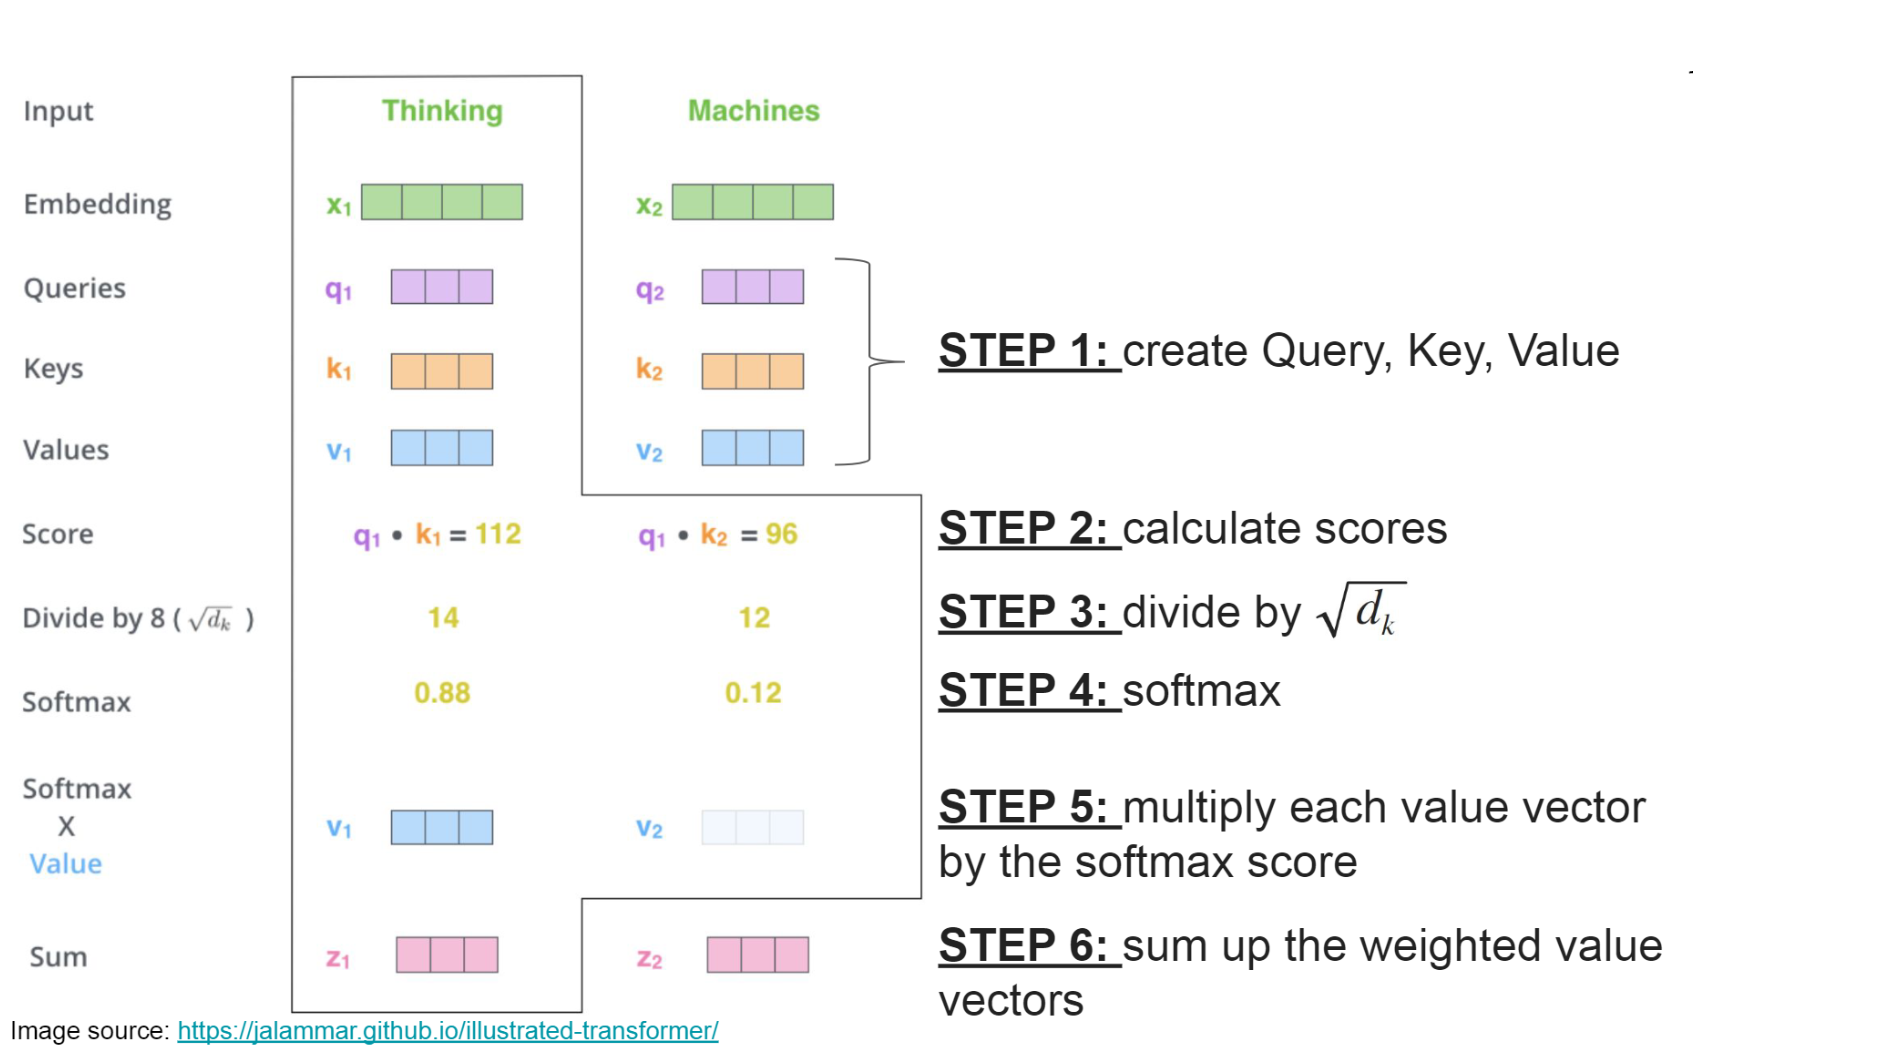

## Multi-headed attention

In the case of multiple heads, each of them can catch different types of connections between words.

# Practical implementation

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
import scipy.special
import math

In [2]:
def create_tensor(t):
    """Function for creating an np.array array from a list of lists

      Arguments:
        t: list of lists

      Returns:
        np.ndarray
    """
    return np.array(t)

def print_tensor(t, name):
    """Displaying the size of the tensor and itself"""
    print(f'{name} shape: {t.shape}\n {t}\n')

In [3]:
assert create_tensor([[1, 0, 0], [0, 1, 0]]).shape == (2, 3)
assert type(create_tensor([[1, 2, 3], [4, 5, 6]])) == np.ndarray

In [4]:
q = create_tensor([[1, 0, 0], [0, 1, 0]])
print_tensor(q, 'query')
k = create_tensor([[1, 2, 3], [4, 5, 6]])
print_tensor(k, 'key')
v = create_tensor([[0, 1, 0], [1, 0, 1]])
print_tensor(v, 'value')
m = create_tensor([[0, 0], [-1e9, 0]])
print_tensor(m, 'mask')

query shape: (2, 3)
 [[1 0 0]
 [0 1 0]]

key shape: (2, 3)
 [[1 2 3]
 [4 5 6]]

value shape: (2, 3)
 [[0 1 0]
 [1 0 1]]

mask shape: (2, 2)
 [[ 0.e+00  0.e+00]
 [-1.e+09  0.e+00]]



In [5]:
def dotProdAtt(query, key, value, mask, scale=True):
    """Self attention with a scalar product
    """
    assert query.shape[-1] == key.shape[-1] == value.shape[-1], "There is a problem with q, k, v - dimentions differ"
    query = torch.tensor(query)
    key = torch.tensor(key)

    # We preserve the depth/dimension of the embedding of the query to reduce the scale of the scalar product
    if scale: 
        depth = query.shape[-1]
    else:
        depth = 1


    # Calculate the scaled scalar product of the key on query according to the formula above (the matmul and swapaxes functions may be useful)

    dots = np.matmul(query, np.swapaxes(key, 0, 1)) / math.sqrt(depth)
    # Применим маску
    if mask is not None:
        dots = np.where(mask, dots, np.full_like(dots, -1e9))
    # Calculate softmax
    # The scipy.special.logsumexp function avoids problems with dividing by large numbers

    logsumexp = scipy.special.logsumexp(dots, axis=-1, keepdims=True)

    # Getting sotmax
    dots = np.exp(dots - logsumexp)

    # Multiply dots by value to get self-awareness
    # Use np.matmul()

    attention = np.matmul(dots, value)
    return attention

Расчитываем маскированное самовнимание - специальный случай скалярного внимания 

In [6]:
def dotProdSelfAtt(q, k, v, scale=True):
    """ Маскированное самовнимание
    """
    
    # Size of the penultimate dimension of the query
    mask_size = q.shape[0]

    # Creating a matrix with units under the main diagonal and 0 above it. Final dimension: (1, mask_size, mask_size)
    # Use np.tril() and np.ones()
    
    mask = np.tril(np.ones((1, mask_size, mask_size), dtype=np.bool_))

    assert np.allclose(mask, np.array([[[1., 0.],
                                        [1., 1.]]]))
    mask = mask.astype(bool)

    return dotProdAtt(q, k, v, mask, scale=scale)

In [7]:
assert np.allclose(dotProdSelfAtt(q, k, v),
                   np.array([[[0., 1., 0.],[0.84967455, 0.15032545, 0.84967455]]])), "no ok!"

In order to calculate the final value of attention, it is necessary to calculate the following formula $\textrm{softmax} \left(\frac{Q K^T}{\sqrt{d}}+M\right) V$, where $\sqrt{d}$ is the scaling factor equal to the square root of the embedding dimension, M is the mask, Q is the query, K is the key and V is the value.

# PART 2 - BERT (10 points)

This task contains an analysis of the use of pre-trained models for text processing, some of the functions need to be completed independently. There are assertions in the code to help verify that your logic is most likely correct.

## Classification of sentiment

Based on a dataset of movie reviews, we want to determine the user's mood (sentiment) and predict 1 - if positive sentiment and 0 - if negative.

In fact, we have not one model for this task, but two:
- DistilBERT is a lighter version of BERT created by HuggingFace, while showing a final quality close to BERT. The model processes the offer and passes some extracted features to the next model.
- Logistic regression from sklearn for final classification into positive and negative sentiment

In [8]:
!pip install transformers

## Loading and preparing

In [9]:
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)

To speed up processing, we will take only 3000 sentences from the dataset

In [10]:
N = 3000
batch_1 = df[:N]
batch_1[1].value_counts()

1    1565
0    1435
Name: 1, dtype: int64

Loading the pre-trained model

In [12]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer,
                                                    'distilbert-base-uncased')

# Loading pre-trained models/tokenizers (see from_pretrained method)
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# We translate the text for the format acceptable for bert
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [14]:
assert tokenized[0] == [101, 1037, 18385, 1010, 6057, 1998, 2633, 18276, 2128, 16603, 1997, 5053, 1998, 1996, 6841, 1998, 5687, 5469, 3152, 102]

As you remember, each sentence is tokenized, and in order for Bert to be able to process all the examples in one batch, it is necessary to bring all the lists to the same size using padding.

In [15]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [16]:
assert np.array(padded).shape == (3000, 66)

In order not to confuse the model, it is necessary to create another variable containing a mask that will help ignore paddings during processing. Hint: The mask should contain units where the input is not equal to the padding index (see np.where).

In [17]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(3000, 66)

In [18]:
assert len(attention_mask[0] == 1) == 66

## Getting embeddings of offers

The model() function runs sentences through bert.

In [19]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

The peculiarity of bert is that he adds a special token [CLS] to the beginning of the sentence, the output of which corresponds to the embedding of the whole sentence

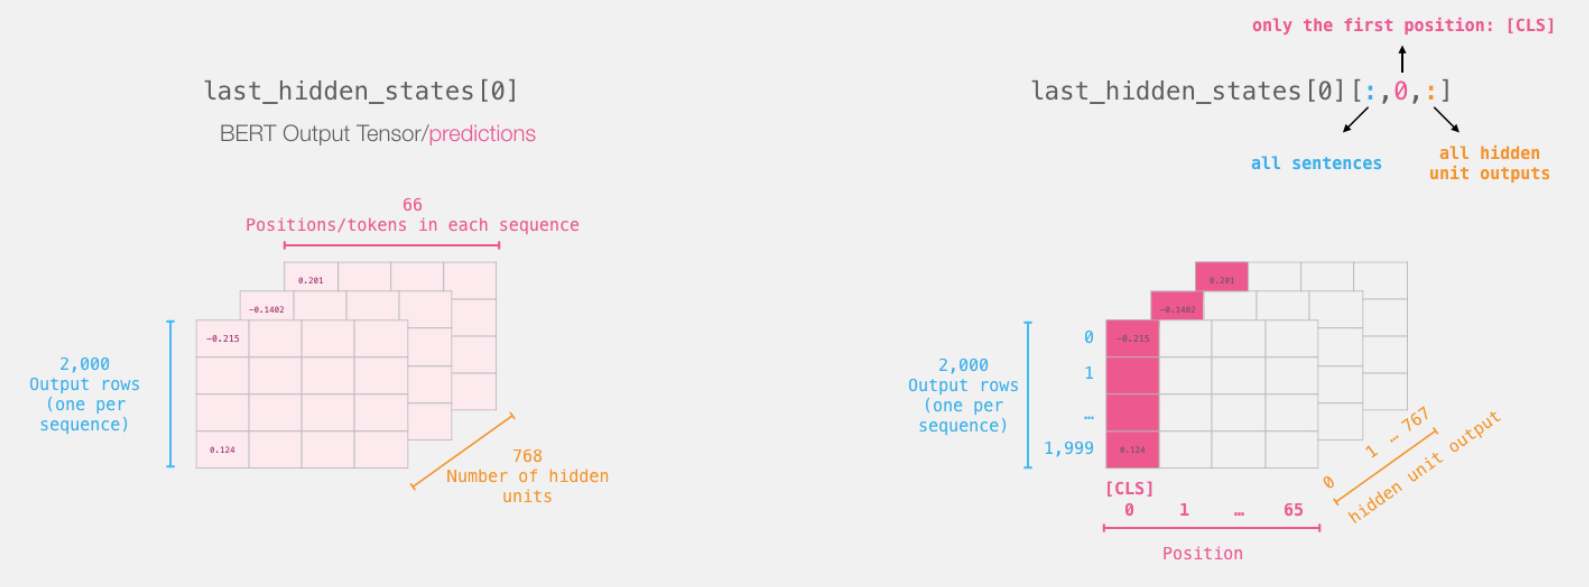

In [20]:
last_hidden_states[0].shape

torch.Size([3000, 66, 768])

In [21]:
features = last_hidden_states[0][:,0,:].numpy()

In [22]:
# we save the labels of positive and negative sentences to the labels variable
labels = batch_1[1]

## Divide the data into train and test for classification and select parameters

In [23]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

Using sklearn, you can automatically select parameters. In the case of logistic regression, it is worth finding the best parameter C that determines the strength of regularization.

In [24]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 5.263252631578947}
best scrores:  0.8333333333333334


In [25]:
assert grid_search.best_params_['C'].round(2) == 5.26, "no ok!"

In [26]:
lr_clf = LogisticRegression(C=grid_search.best_params_['C'])
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=5.263252631578947)

## Quality estimation

In [27]:
lr_clf.score(test_features, test_labels)

0.8133333333333334

For the purity of the experiment, we will find out the quality of the random classifier

In [45]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.526 (+/- 0.00)
